In [1]:
versionname = "random"

In [2]:
## Imports

import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
k = 30
nbags = 10
bag_contfactor = .4
seed = 1302

In [7]:
## Construct dataset
# 15 bags
# 35 instances/bag
import sys
from PUMILADmain.create_ds_2 import gen_data

bags, bags_labels, X_inst, y_inst = gen_data(k = k, nbags = nbags, bag_contfactor = bag_contfactor, seed = seed)

D= bags
bags = np.array(list(bags.values()))
a = {}
for k, v in D.items():
    a[k] = v[:,:2]
print(a)


{0: array([[  1.80082652,   0.86782827],
       [  2.73458323,   0.72535352],
       [  2.47287238,   0.98133658],
       [  1.07480599,   6.98904979],
       [ -0.86018144,   7.95423439],
       [ -2.58226139,   9.13808889],
       [  8.7809824 ,  -0.19160427],
       [  6.20419672,  -5.67560935],
       [  2.30506527,  -3.00447568],
       [  5.50835403,  -1.22334598],
       [  3.69288724,   3.01844114],
       [  3.74831349,  -0.34088255],
       [  3.13832457,   1.55272667],
       [  3.42284996,   5.5579491 ],
       [ -7.14445743,  -0.76912231],
       [ -7.31361045,  -1.22049981],
       [ -7.19592617,  -0.26830489],
       [ -6.74552078,   0.16068801],
       [ -9.77156931,  -5.81005648],
       [ -8.2686177 ,  -4.88138265],
       [  0.546927  ,  -0.33805723],
       [ -0.17199672,   0.38400785],
       [  6.73698853,  -4.84567558],
       [  8.11821087,  -4.70963093],
       [  6.21672784,  -4.45297454],
       [  5.40293904,  -5.10651503],
       [ -4.86870391,   5.27827823

In [84]:
from dataBag import DataBag
from rewardInfo import RewardInfo

dataBag = DataBag(bags, bags_labels, X_inst, y_inst)
rewardInfo = RewardInfo(len(bags_labels))

clrs = ['b','g','r','c','m','k','y', 'lime','deeppink','aqua','yellow','gray','darkorange','saddlebrown','salmon']

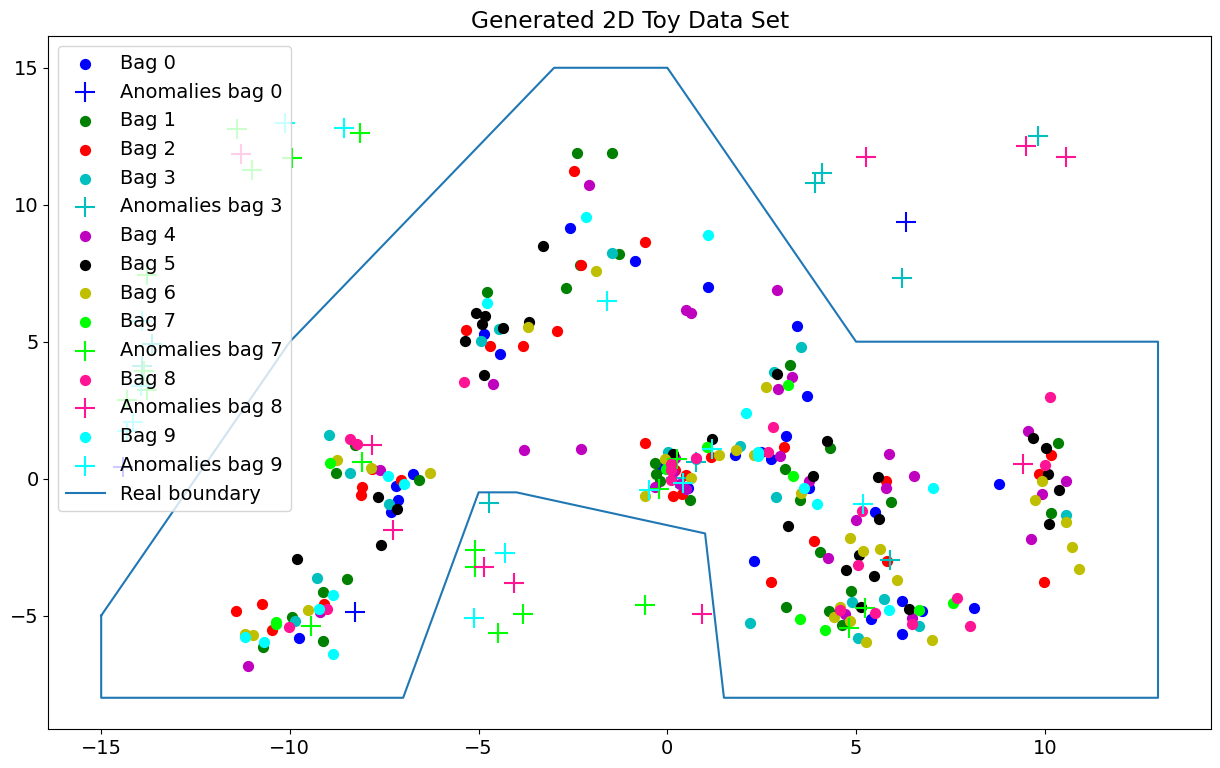

In [85]:
## Create toy data set

from itertools import cycle
cycol = cycle(clrs)

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(15,9) )  # create figure & 1 axis

for bag in range(len(bags)):
    domain = bags[bag]
    anomalies = []
    normals = []
    D[bag] = np.asarray(domain.tolist())

    for idx in range(len(domain)):
        if dataBag.isAnomaly(bag, idx):
            anomalies.append(domain[idx])
        else:
            normals.append(domain[idx])

    anomalies = np.asarray(anomalies)
    normals = np.asarray(normals)
    
    c=next(cycol)
    if (len(normals)>0):
        ax.scatter(normals[:,0], normals[:,1], marker='.', c=c, s=200, label="Bag "+str(bag))#, c= 'b')
    if (len(anomalies)>0):
        ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c, s=200, label = "Anomalies bag "+str(bag))#,c= 'b')


'''for bag in range(len(bags)):
    domain = bags[bag]
    if (len(domain)>0):
        ax.scatter(domain[:,0], domain[:,1], c=next(cycol))'''
        
m = np.asarray([[-15,-5],[-10,5],[-3,15], [0,15],[5,5],[13,5],[13,-8],[1.5,-8],[1,-2],[-4,-.5],[-5,-.5],[-7,-8],[-15,-8],[-15,-5]])
ax.plot(m[:,0], m[:,1], label = "Real boundary")
#plt.legend(["Bag "+str(i+1) for i in range(len(bags))]+['Real boundary'])
plt.legend()
fig.savefig('img/original.png',bbox_inches='tight')
plt.title('Generated 2D Toy Data Set')
plt.show()
plt.close(fig)


In [86]:
from data import Data
from methods import MABMethod
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve

def getPrediction(alba: MABMethod, data: Data):
    pos = {}
    neg = {}
    probabilities = alba.predict(data, True)
    return probabilities
    '''for key in predictions.keys():
        posdummy = []
        negdummy = []
        for i in range(len(predictions[key])):
            if predictions[key][i]==-1:
                negdummy.append(data.get_domain(key)[i])
            elif predictions[key][i]==1:
                posdummy.append(data.get_domain(key)[i])
        pos[key] = np.asarray(posdummy)
        neg[key] = np.asarray(negdummy)
    return neg, pos, predictions'''

def diff2dd(A, B):
    # https://stackoverflow.com/questions/8317022/get-intersecting-rows-across-two-2d-numpy-arrays
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [A.dtype]}

    C = np.setdiff1d(A.view(dtype), B.view(dtype))

    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

def noisyOr(labels):
    lst = np.zeros((len(labels.keys())))
    for bag in labels.keys():
        lbls = np.array(labels[bag])
        lbls = 1-lbls
        lst[bag] = 1-np.prod(lbls)
    return lst

def currentPrediction(alba, data: Data, bags, bags_labels, newinstanceKey, instance, labeledPos = None, labeledNeg = None, t=0, y_inst = []):
    

    '''cycol = cycle(clrs)

    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 

    
    m = np.asarray([[-15,-5],[-10,5],[-3,15], [0,15],[5,5],[13,5],[13,-8],[1.5,-8],[1,-2],[-4,-.5],[-5,-.5],[-7,-8],[-15,-8],[-15,-5]])
    ax.plot(m[:,0], m[:,1])

    for bag in range(len(bags)):
        domain = bags[bag]
        pos = np.asarray(labeledPos[bag])
        neg = np.asarray(labeledNeg[bag])
        domain = diff2dd(domain, pos)
        domain = diff2dd(domain, neg)
        c = next(cycol)

        if (len(domain)>0):
            ax.scatter(domain[:,0], domain[:,1], c=c)
        
        if (len(pos)>0):
            ax.scatter(pos[:,0], pos[:,1], marker = '+', c=c)
        if (len(neg)>0):
            ax.scatter(neg[:,0], neg[:,1], marker = '_', c=c)


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('img/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)
    '''


    probabilities = getPrediction(alba, data)
    '''nrows = 3
    ncols = 4
    fig, axs = plt.subplots( nrows=nrows, ncols=ncols ,figsize=(16,9)) 
   
    m = np.asarray([[-15,-5],[-10,5],[-3,15], [0,15],[5,5],[13,5],[13,-8],[1.5,-8],[1,-2],[-4,-.5],[-5,-.5],[-7,-8],[-15,-8],[-15,-5]])
    for bag in range(len(bags)):
        ax = axs[bag//ncols, bag-ncols*(bag//ncols)]
        ax.plot(m[:,0], m[:,1])
        domain = bags[bag]
        ax.scatter(domain[:,0], domain[:,1], c =probabilities[bag], cmap = 'gray')
        if (bag == newinstanceKey):
            ax.scatter(instance[0], instance[1], c='red')


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('colorimg/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)
    '''



    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 
    m = np.asarray([[-15,-5],[-10,5],[-3,15], [0,15],[5,5],[13,5],[13,-8],[1.5,-8],[1,-2],[-4,-.5],[-5,-.5],[-7,-8],[-15,-8],[-15,-5]])
    ax.plot(m[:,0], m[:,1], label ='Real boundary')
    domain = np.zeros((0,3))
    prs = np.zeros((0))
    for bag in range(len(bags)):
        domain = np.concatenate((domain,bags[bag]))
        prs = np.concatenate((prs, probabilities[bag]))
    
    z = ax.scatter(domain[:,0], domain[:,1], c = prs , cmap = 'coolwarm',  s=200, edgecolors='k')
    ax.scatter(instance[0], instance[1], c='lime',label = "Selected instance",s=400, edgecolors='k')


    scoreroc = roc_auc_score(np.rint(y_inst), prs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(y_inst), prs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scorepr = auc(recall, precision)
    bagprobs = noisyOr(probabilities)
    scorerocBag = roc_auc_score(np.rint(bags_labels), bagprobs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(bags_labels), bagprobs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scoreprBag = auc(recall, precision)

    plt.title('Iteration '+str(t).zfill(3), fontsize = 16)
    rewardInfo.updateAuc("roc", scoreroc)
    rewardInfo.updateAuc("pr", scorepr)
    rewardInfo.updateAuc("rocbag", scorerocBag)
    rewardInfo.updateAuc("prbag", scoreprBag)

    
    textstr = "ROC AUC = {:.10f}\nPR AUC = {:.10f}\nROC AUC BAG= {:.10f}\nPR AUC BAG= {:.10f}".format(scoreroc, scorepr, scorerocBag, scoreprBag)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props)
    
    cbar = fig.colorbar(z,ax= ax, label ="higher score = more positive")
    tick_font_size = 14
    cbar.ax.tick_params(labelsize=tick_font_size)
    plt.rcParams.update({'font.size': 14})
    ax.legend(loc = "lower right", fontsize= 14)

    fig.savefig('colorimg2/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)


In [87]:
## Create 2 domains
training_data = Data(nbags)
print(nbags)
print(D)
training_data.set_domains_and_labels(D)
query_budget = 20#nbags*k#50 #30*10
alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo , al_strategy = "random")

10
{0: array([[  1.80082652,   0.86782827,   0.07093979],
       [  2.73458323,   0.72535352,  -1.26759912],
       [  2.47287238,   0.98133658,   0.23180074],
       [  1.07480599,   6.98904979,  -0.20510845],
       [ -0.86018144,   7.95423439,   0.19797154],
       [ -2.58226139,   9.13808889,  -0.22143564],
       [  8.7809824 ,  -0.19160427,  -0.14744358],
       [  6.20419672,  -5.67560935,  -0.47324815],
       [  2.30506527,  -3.00447568,  -0.12409608],
       [  5.50835403,  -1.22334598,   1.44280495],
       [  3.69288724,   3.01844114,  -0.70049697],
       [  3.74831349,  -0.34088255,   0.3774628 ],
       [  3.13832457,   1.55272667,   0.29526622],
       [  3.42284996,   5.5579491 ,  -1.6984149 ],
       [ -7.14445743,  -0.76912231,   0.24008047],
       [ -7.31361045,  -1.22049981,  -1.15171678],
       [ -7.19592617,  -0.26830489,  -0.31948498],
       [ -6.74552078,   0.16068801,   0.60718576],
       [ -9.77156931,  -5.81005648,  -0.85084585],
       [ -8.2686177 ,  -

none
0
1
2


KeyboardInterrupt: 

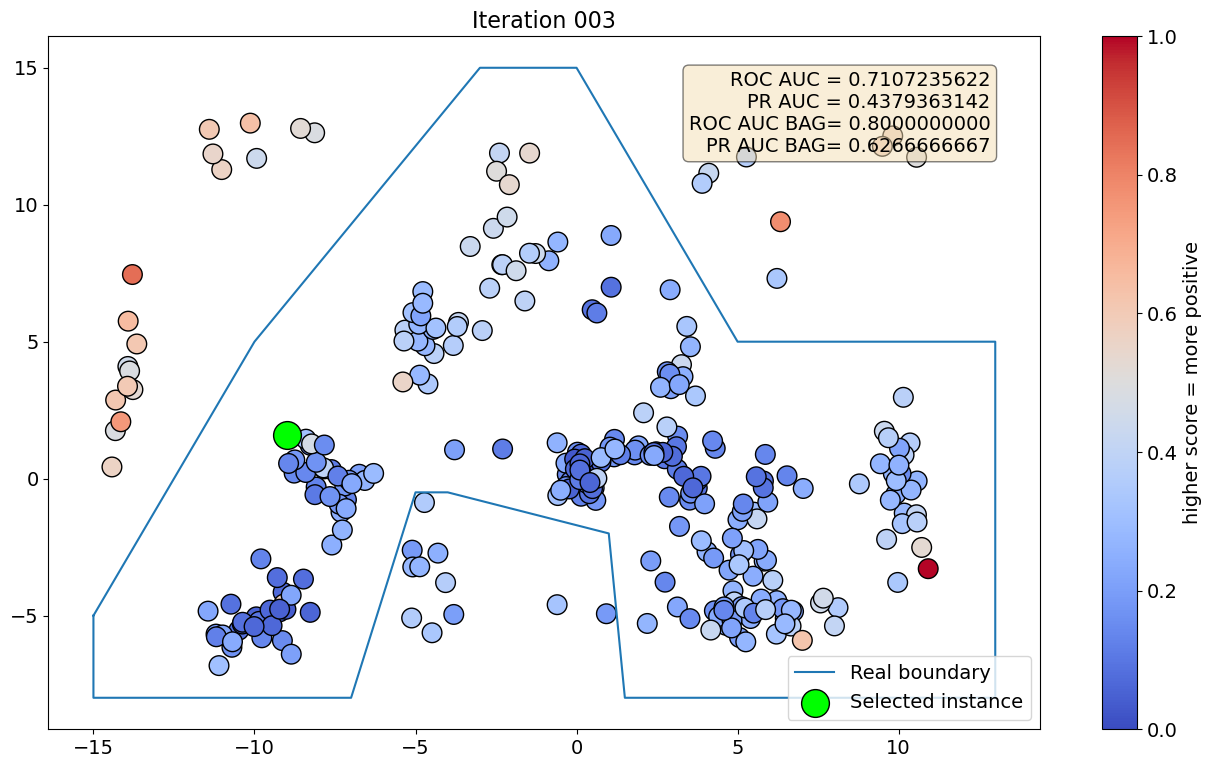

In [88]:

t = 0  
labeledPos = {}
labeledNeg = {}
for bag in range(len(bags)):
    labeledNeg[bag] = []
    labeledPos[bag] = []
performance = []

import warnings
warnings.filterwarnings('ignore')

while(t<query_budget):
    queries = alba.fit_query(training_data, True)

    #!!!!!!!
    key,idx = queries[0]
    i = 0
    while dataBag.isLabeled(key,idx):
        i+=1
        key, idx = queries[i]
    

    rewardInfo.chooseArm(key)
    key,idx = queries[i]
    instance = training_data.get_domain(key)[idx]
    lbl = dataBag.getLabel(key, idx)
    training_data.set_new_label(key, idx, lbl)
    training_data.set_last_labeled(key,idx)
    
    dataBag.label(key,idx)
    
    
    if (lbl == 1):
        labeledPos[key].append(instance.tolist())
    else:
        labeledNeg[key].append(instance.tolist())

    currentPrediction(alba, training_data, bags, bags_labels, key, instance, labeledPos,labeledNeg, t, y_inst)
    
    #performance.append(dataBag.measureAccuracy(predictions))
    print(t)
    t += 1

## window = 10!!!

In [ ]:
import cv2
import os

image_folder = 'img'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
print(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()

image_folder = 'colorimg'
video_name = 'videocolorimg.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
print(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()

image_folder = 'colorimg2'
video_name = 'videocolorimg2.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
print(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()

['iteration000.png', 'iteration001.png', 'iteration002.png', 'iteration003.png', 'iteration004.png', 'iteration005.png', 'iteration006.png', 'iteration007.png', 'iteration008.png', 'iteration009.png', 'iteration010.png', 'iteration011.png', 'iteration012.png', 'iteration013.png', 'iteration014.png', 'iteration015.png', 'iteration016.png', 'iteration017.png', 'iteration018.png', 'iteration019.png', 'iteration020.png', 'iteration021.png', 'iteration022.png', 'iteration023.png', 'iteration024.png', 'iteration025.png', 'iteration026.png', 'iteration027.png', 'iteration028.png', 'iteration029.png', 'iteration030.png', 'iteration031.png', 'iteration032.png', 'iteration033.png', 'iteration034.png', 'iteration035.png', 'iteration036.png', 'iteration037.png', 'iteration038.png', 'iteration039.png', 'iteration040.png', 'iteration041.png', 'iteration042.png', 'iteration043.png', 'iteration044.png', 'iteration045.png', 'iteration046.png', 'iteration047.png', 'iteration048.png', 'iteration049.png',

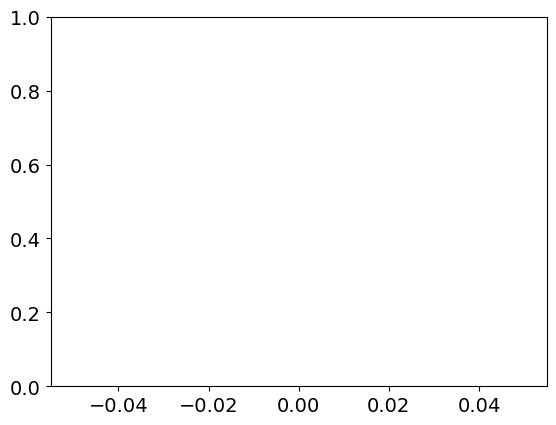

In [ ]:
plt.plot(performance)
plt.ylim([0,1])
plt.show()




## Not a lot of difference between random queries or the ALBA paper./weird choice of queries
## This makes sense!
## ALBA first selects the most promising bag and then selects an instance randomly.
## However, both bags have the same distribution, so in practice, it does not change 
# a lot which bag you pick first, because thereafter you pick a random instance and 
# the chance is a lot bigger to pick a negative instance instead of a positive one.
## So basically, ALBA right now (for same distributions) performs the same as random querying.

## The predictions are weird (a queried label is sometimes falsely predicted)
## Does this make sense because we use isolation forests? Or must the code cope with that?

## Rotting bandits paper: formula 1 unclear

[0.01995457526090034, 0.009935301616471052]
[0.044307969273652235, 0.02001581027978748]
[0.022555875907707704, 0.010864858879606821]
[0.006336973074601492, 0.03863519037616524]
[0.021485474128753432, 0.009557967257961144]
[0.028735032642990183, 0.02959219965610392]
[0.011588712587682777, 0.005955449800072662]
[0.01920134672176585, 0.017528007141042967]
[0.0055528923229180025, 0.012266876508604477]
[0.014963514899091632]


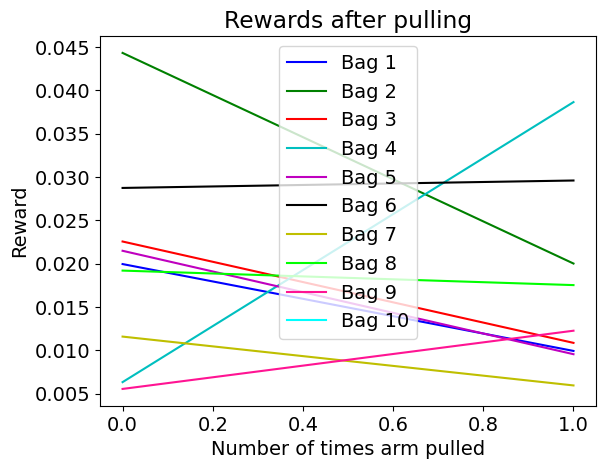

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.33333333

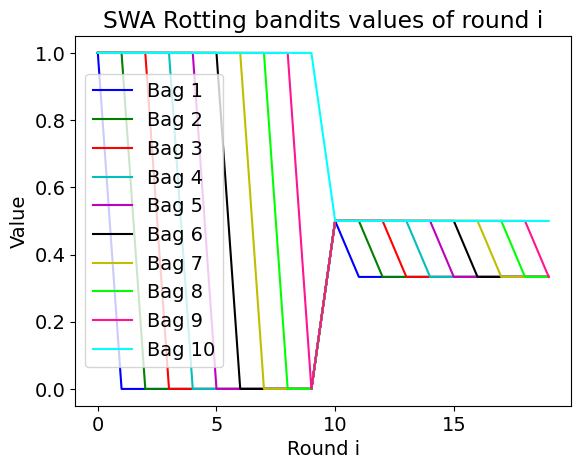

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


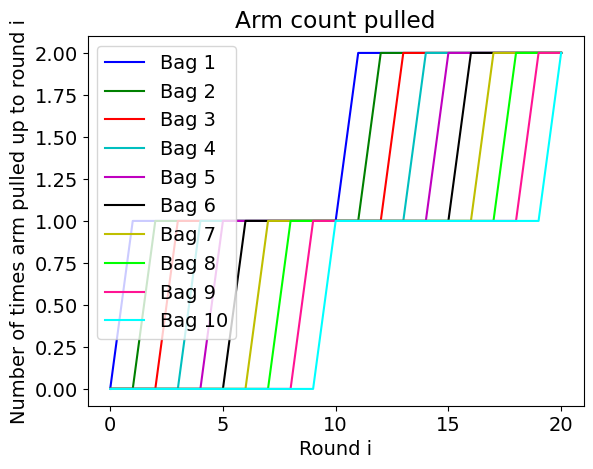

In [ ]:
cycol = cycle(clrs)

fig, ax = plt.subplots( nrows=1, ncols=1 ) 

for bag in range(len(bags)):
    rewards = rewardInfo.getRewards(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(rewards, c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('Rewards after pulling')
plt.ylabel('Reward')
plt.xlabel('Number of times arm pulled')
fig.savefig('img/rewards.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getBanditRewards(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(rewards, c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('SWA Rotting bandits values of round i')
plt.ylabel('Value')
plt.xlabel('Round i')
fig.savefig('img/rewardsSWA.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getChosenArm(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(rewards, c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('Arm count pulled')
plt.ylabel('Number of times arm pulled up to round i')
plt.xlabel('Round i')
fig.savefig('img/rewardsChosen.png',bbox_inches='tight')
plt.show()
plt.close(fig)


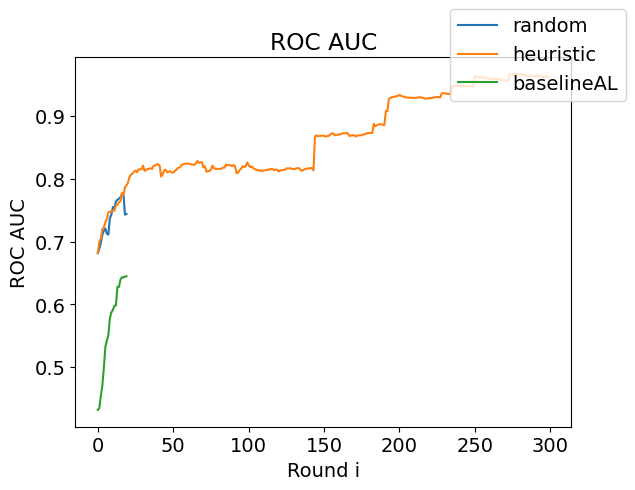

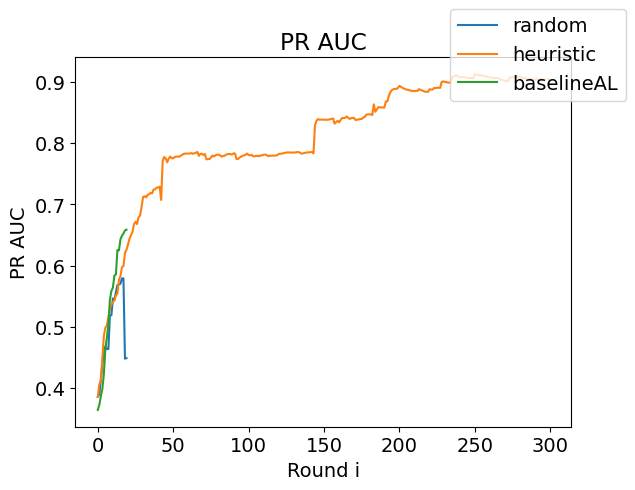

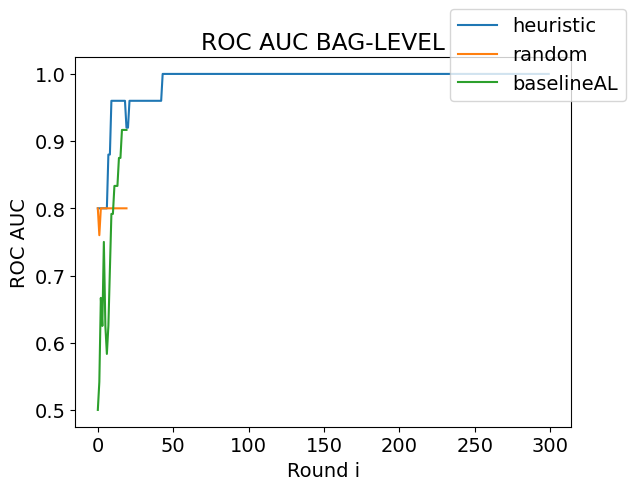

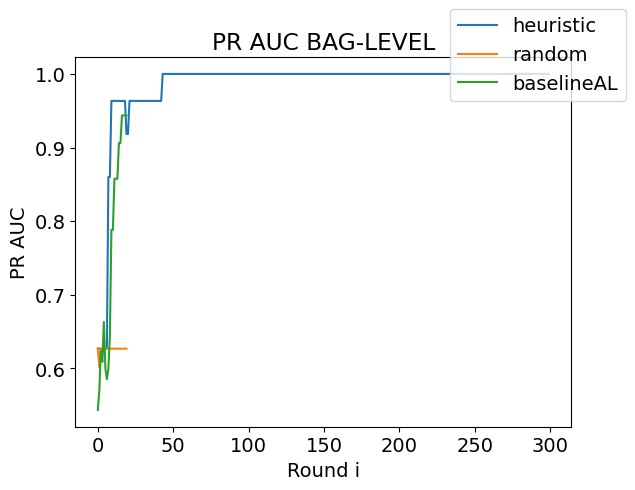

-1


In [ ]:
'''t = rewardInfo.getIterationEndRoundRobin()

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getBanditRewards(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(range(t, t+len(rewards[t:])),rewards[t:], c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('SWA Rotting bandits values of round i')
plt.ylabel('Value')
plt.xlabel('Round i')
fig.savefig('img/rewardsSWAAfterRR.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getChosenArm(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(range(t, t+len(rewards[t:])),rewards[t:], c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('Arm count pulled')
plt.ylabel('Number of times arm pulled up to round i')
plt.xlabel('Round i')
fig.savefig('img/rewardsChosenAfterRR.png',bbox_inches='tight')
plt.show()
plt.close(fig)


cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getChosenArm(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(range(t, t+len(rewards[t:])),rewards[t:], c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('Arm count pulled')
plt.ylabel('Number of times arm pulled up to round i')
plt.xlabel('Round i')
fig.savefig('img/rewardsChosenAfterRR.png',bbox_inches='tight')
plt.show()
plt.close(fig)'''

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["roc"]
import csv
with open('auc_roc.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_roc.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Round i')
fig.savefig('img/ROC AUC.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["pr"]
import csv
with open('auc_pr.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_pr.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('PR AUC')
plt.ylabel('PR AUC')
plt.xlabel('Round i')
fig.savefig('img/PR AUC.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)


## BAGLEVEL

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["rocbag"]
import csv
with open('auc_roc_bag.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_roc_bag.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('ROC AUC BAG-LEVEL')
plt.ylabel('ROC AUC')
plt.xlabel('Round i')
fig.savefig('img/ROC AUC BAG.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["prbag"]
import csv
with open('auc_pr_bag.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_pr_bag.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('PR AUC BAG-LEVEL')
plt.ylabel('PR AUC')
plt.xlabel('Round i')
fig.savefig('img/PR AUC BAG.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)

print(rewardInfo.getIterationEndRoundRobin())
